# VB03 - Black Box Variational Inference for Logistic Regression

# Keyon Vafa  $\mskip100mu$ _2017-04-01_

Code is in Python, Black Box Variational Inference is described <a href='http://keyonvafa.com/variational-inference-probit-regression/'>here</a>. 
Based on <a href='http://keyonvafa.com/logistic-regression-bbvi/'>blog post</a>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm

## Generate simulated dataset for logistic regression

### $N=$ Number of observations, $P=$ number of predictors

In [2]:
N = 100
P = 4

### $X = $ predictors matrix, an $N\times P$ matrix, $y=$ responses, an $N$-vector of 0's and 1's

In [3]:
rs = np.random.RandomState(0)
X = rs.randn(N,P)
z_real = rs.randn(P)
y = rs.binomial(1,sigmoid(np.dot(X,z_real)))

In [4]:
X.shape, y.shape

((100, 4), (100,))

## ELBO Gradient

In [5]:
def elbo_grad(z_sample, mu, sigma):
    score_mu = (z_sample - mu)/(sigma)
    score_logsigma = (-1/(2*sigma) + np.power((z_sample - mu),2)/(2*np.power(sigma,2))) * sigma
    log_p = np.sum(y * np.log(sigmoid(np.dot(X,z_sample))) + (1-y) * np.log(1-sigmoid(np.dot(X,z_sample))))\
        + np.sum(norm.logpdf(z_sample, np.zeros(P), np.ones(P)))
    log_q = np.sum(norm.logpdf(z_sample, mu, np.sqrt(sigma)))
    return np.concatenate([score_mu,score_logsigma])*(log_p - log_q)

## Run simulation

### Set parameters

In [6]:
rs = np.random.RandomState(0)
S = 10
n_iter = 10000
mu = rs.randn(P)
G = np.zeros((2*P,2*P))
eta = 1.0
log_sigma = rs.randn(P)
mus = np.zeros((n_iter,P))
delta_lambda = np.zeros(n_iter)

### $\dots$ and iterate

In [7]:
print("Beginning to optimize")
for t in range(n_iter):
    mus[t] = mu
    if t % 500 == 0:
        print("Iteration: ", t)
        print("Mu: ", mu)
        print("Sigma: ", np.exp(log_sigma))
    sigma = np.exp(log_sigma)
    samples = np.array([rs.normal(mu, np.sqrt(sigma)) for s in range(S)])
    grad_estimate = np.mean(np.array([elbo_grad(z_sample, mu, sigma) for z_sample in samples]),axis=0)
    G = G + np.outer(grad_estimate,grad_estimate)
    mu_new = mu + (eta * 1/np.sqrt(np.diag(G)))[:P] * grad_estimate[:P]
    log_sigma_new = log_sigma + (eta * 1/np.sqrt(np.diag(G)))[P:] * grad_estimate[P:]
    delta_lambda[t] = np.linalg.norm(mu_new-mu)
    if np.linalg.norm(mu_new-mu) < 0.01:
        break
    mu = mu_new
    log_sigma = log_sigma_new
print("Optimization complete")
print("Final mu: ", mu)
print("Final sigma: ", np.exp(log_sigma))
print("Real values: ", z_real)

Beginning to optimize
Iteration:  0
Mu:  [1.76405235 0.40015721 0.97873798 2.2408932 ]
Sigma:  [6.47247125 0.37633413 2.58593829 0.85954061]
Iteration:  500
Mu:  [-0.79553343 -1.74296326  1.10009031  0.44446444]
Sigma:  [0.19822677 0.13143896 0.08315484 0.29420238]
Iteration:  1000
Mu:  [-0.614433   -0.6808173   0.55535877 -0.06988163]
Sigma:  [0.1011387  0.11051888 0.04587832 0.07709935]
Iteration:  1500
Mu:  [-0.96207594 -1.05083031  0.30623316  1.06491372]
Sigma:  [0.04578764 0.09417719 0.0630919  0.10405764]
Iteration:  2000
Mu:  [-1.22831113 -0.74941993  0.36357895  0.57491856]
Sigma:  [0.05599482 0.11172733 0.06421828 0.11317565]
Optimization complete
Final mu:  [-0.96467262 -0.83627335  0.43183214  0.83248988]
Final sigma:  [0.04940165 0.09677904 0.06591744 0.11994209]
Real values:  [-0.59865394 -1.11589699  0.76666318  0.35629282]


## Show densities and traceplots

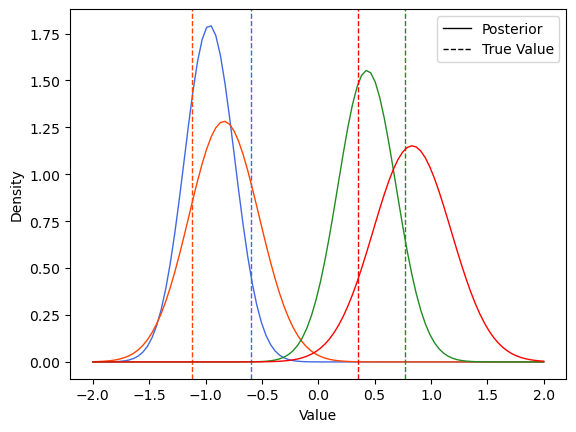

<Figure size 1000x700 with 0 Axes>

In [8]:
%matplotlib inline 
x_plot = np.linspace(-2, 2, 100)
plt.plot(x_plot,norm.pdf(x_plot, mu[0], np.sqrt(sigma[0])),"royalblue",linewidth=1,label="Posterior")
plt.axvline(x=z_real[0],c="royalblue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x_plot,norm.pdf(x_plot, mu[1], np.sqrt(sigma[1])),c="orangered",linewidth=1)
plt.axvline(x=z_real[1],c="orangered",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[2], np.sqrt(sigma[2])),c="forestgreen",linewidth=1)
plt.axvline(x=z_real[2],c="forestgreen",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[3], np.sqrt(sigma[3])),c="red",linewidth=1)
plt.axvline(x=z_real[3],c="red",linestyle='dashed',linewidth=1)
plt.xlabel("Value")
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legend_handles[0].set_color('black')
leg.legend_handles[1].set_color('black')
#plt.savefig('densities.png', format='png',bbox_inches='tight',dpi = 300)
plt.figure(figsize=(10,7))
plt.show()

<figure>
<img src="./Img/Vafa.Keyon.densities.jpg" alt="Vafa.Keyon.densities" style="width:35%">
<figcaption>Vafa Keyon Densities Figure</figcaption>
</figure>

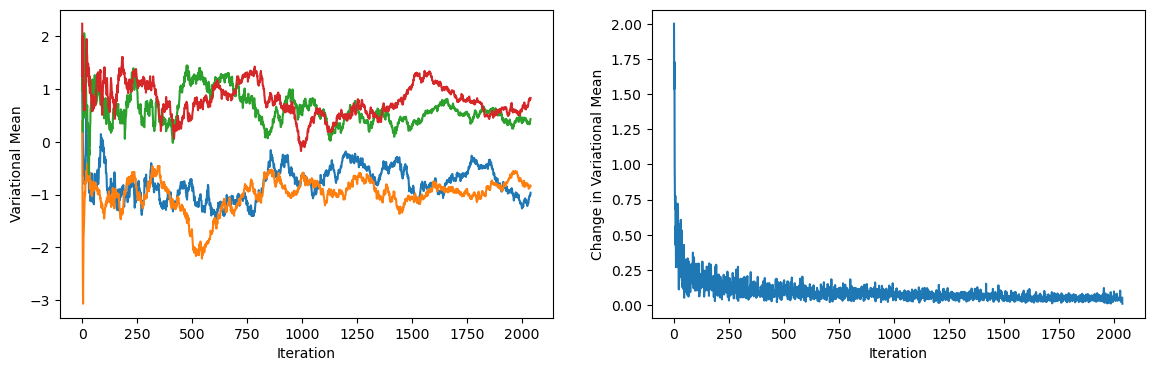

In [9]:
fig = plt.figure(figsize=(14,4), facecolor='white')
ax_1 = fig.add_subplot(121, frameon=True)
ax_2 = fig.add_subplot(122, frameon=True)
ax_1.plot(range(t+1),mus[:(t+1)])
ax_1.set_xlabel("Iteration")
ax_1.set_ylabel("Variational Mean")
ax_2.plot(range(t+1),delta_lambda[:(t+1)])
ax_2.set_xlabel("Iteration")
ax_2.set_ylabel("Change in Variational Mean")
#plt.savefig('trace_plots.png', format='png',bbox_inches='tight',dpi=300)
plt.show()

<figure>
<img src="./Img/Vafa.Keyon.trace_plots.jpg" alt="Vafa.Keyon.trace_plots" style="width:70%">
<figcaption>Vafa Keyon Densities Figure</figcaption>
</figure>